#### Trajectory analysis tools <font color="DarkSeaGreen">/ GROMACS-on-Colab</font>
<small>Suite: [`Build_to_Google_Drive.ipynb`](https://colab.research.google.com/github/bioinfkaustin/gromacs-on-colab/blob/main/Build_to_Google_Drive.ipynb) | [`GROMACS_for_CHARMM-GUI.ipynb`](https://colab.research.google.com/github/bioinfkaustin/gromacs-on-colab/blob/main/GROMACS_for_CHARMM-GUI.ipynb) | [`GROMACS_for_production.ipynb`](https://colab.research.google.com/github/bioinfkaustin/gromacs-on-colab/blob/main/GROMACS_for_production.ipynb) | `Trajectory_analysis_tools.ipynb`</small>

#### Documentation
Please click ***↳ cells hidden*** below to show the documentation for this notebook.

##### License

> This notebook as a work of software is licensed under the terms of the [AGPL-3.0](https://opensource.org/licenses/AGPL-3.0) or later.

##### About this software

> This notebook allows a number of **analysis tools** to be run on a simulated trajectory. A description of each tool is provided in its respective code cell.
>
> The specified **run folder** must contain the final output of a production simulation (e.g. `sim_reference.xtc`), on which the analyses will be performed.

##### Installation

> The installation notebook, [`Build_to_Google_Drive.ipynb`](https://colab.research.google.com/github/bioinfkaustin/gromacs-on-colab/blob/main/Build_to_Google_Drive.ipynb), must be run before using this notebook.

#### Configuration

In [19]:
%%capture

import os
import re
import shutil

#@markdown Specify the location of the **GROMACS project folder** to analyse. It should contain the outputs from a production run, e.g. `sim.gro`, `sim.trr` and/or `sim.xtc`, and so on.
project_folder = "{GoogleDrive}/Result/hmuscosa1" #@param {type: "string"}
# default: {GoogleDrive}/GROMACS/7FBF_FABPH_vs_octanoic_acid

#@markdown Provide the unique filename prefix used for the simulation.
output_prefix = "sim" #@param {type: "string"}
# default: sim

#@markdown **After filling in this form, run the notebook by clicking *Runtime -> Run all* in the toolbar.**


#
# Google Drive
#

if not os.path.isdir("/home/aistudio") and project_folder.startswith("{GoogleDrive}"):
  from google.colab import drive
  drive.mount("/home/aistudio")

if not os.path.isdir("/home/aistudio"):
  raise RuntimeError("Error: could not connect to Google Drive")


#
# Methods for parsing and validation
#

def _path(s, exists=False):
  if "{GoogleDrive}" in s and not s.startswith("{GoogleDrive}"):  raise ValueError(f"Error: {{GoogleDrive}} is a path prefix, but appears later: {s}")
  s = s.format(GoogleDrive="/home/aistudio")
  #     ^^^ raises KeyError if any {...} placeholder is present except {GoogleDrive}

  if exists  and not os.path.isdir(s):  raise FileNotFoundError(f"Error: folder not found: {s}")
  return os.path.abspath(s)

def parse(s, mandatory=False, path=False, exists=False):
  s = s.strip()
  # error on e.g. ""
  if mandatory and not s:
    raise ValueError("Error: mandatory setting without value")
  # e.g. {GoogleDrive}/archive.tgz -> /content/drive/MyDrive/archive.tgz
  if path:
    s = _path(s, exists=exists)
  return s


#
# Validate the input values
#

# project_folder

project_folder = parse(project_folder, mandatory=True, path=True, exists=True)


# output_prefix

if not output_prefix:
  raise RuntimeError("Error: an output prefix must be provided")

if not re.match(r"^[0-9a-zA-Z]+$", output_prefix):
  raise RuntimeError(f"Error: special characters are not allowed in output prefix, but got: {output_prefix}")


#
# Make sure that the notebook is in the start folder
#

if "START" not in os.environ or not os.environ["START"]:
  %env START={os.getcwd()}
else:
  %cd {os.environ["START"]}


#
# Use a clean scratch directory for the rest of the run
#

try:
  shutil.rmtree("scratch")
except FileNotFoundError:
  pass
os.makedirs("scratch")
%cd "scratch"


#
# Verbosity
#

#@markdown \
#@markdown By default, only relevant output is displayed. To see the full output, including any error messages, enable the `verbose` option below.
verbose=False #@param {type: "boolean"}
if verbose:
  %env VERBOSE=true
else:
  %env VERBOSE=false

#### Installation

In [20]:
#@markdown In the following cells, applications are downloaded from a **persistent cache** in your Google Drive.
#@markdown
#@markdown This cell sets up the cache folder.

storage = "/home/aistudio/gromacs-on-colab"
%env STORAGE={storage}

env: STORAGE=/home/aistudio/gromacs-on-colab


In [21]:
%%bash
#@markdown **GROMACS** is installed from cache.

if [[ -d "/home/aistudio/gromacs" ]]; then
  exit 0  # already installed
fi

gromacs_vers="2023" #@param {type: "string"}
cache_gromacs="${STORAGE}/gromacs-${gromacs_vers}.tar.gz"

if [[ -s "${cache_gromacs}" ]]; then
  tar -xzf "${cache_gromacs}" -C "/usr/local"
else
  echo "Error: GROMACS installation not found" >&2
  echo "(Have you installed GROMACS to your Google Drive?)" >&2
  exit 1
fi

In [22]:
%%bash
#@markdown The CHARMM36 forcefield is downloaded from cache.

if [[ -d "${START}/charmm36.ff" ]]; then
  exit 0  # already installed
fi

charmm36_vers="jul2022" #@param {type: "string"}
cache_charmm36="${STORAGE}/charmm36-${charmm36_vers}.tar.gz"

if [[ -s "${cache_charmm36}" ]]; then
  tar -xzf "${cache_charmm36}" -C "${START}"
else
  echo "Error: CHARMM36 forcefield installation not found" >&2
  echo "(Have you installed the CHARMM36 forcefield to your Google Drive?)" >&2
  exit 1
fi

#### Input

In [23]:
%%bash -s "$project_folder" "$output_prefix"
project_folder="$1"
output_prefix="$2"
#@markdown Extract the trajectory from the project folder.

if [[ ! -z "$(ls -A)" ]]; then
  exit 0  # already extracted
fi

if [[ ! -d "${project_folder}" ]]; then
  echo "Error: folder not found: ${project_folder}" >&2
  exit 1
fi

pushd "${project_folder}"

cp "grompp.mdp"  "conf.gro"  "restraint.gro"  "index.ndx"  "topol.top"  "${START}/scratch/" 2> /dev/null

top_level_dir="$(realpath .)"
function get_includes_recursively {
  f="$1"
  sed -E "/^#include/!d; s/^#include +['\"]//; s/['\"]$//" "${f}" | while read -r g; do
    d="$(dirname "${g}")"
    b="$(basename "${g}")"
    pushd "${d}" > /dev/null
    get_includes_recursively "${b}"
    echo "$(realpath --relative-to="${top_level_dir}" "${b}")"
    popd > /dev/null
  done
}
get_includes_recursively "topol.top" | while read -r f; do
  cp --parents "${f}" "${START}/scratch/"
done

# Convert old-style backups to new-style backups
ls "${output_prefix}".*~ 2> /dev/null | while read -r f; do
  g="${f:: -1}"
  mv --no-clobber "${f}" "_${g}_" && touch "${g}"
done

cp "${output_prefix}".*  "#${output_prefix}.log".*"#"  "${output_prefix}_reference.xtc"  "${START}/scratch/" 2> /dev/null

popd

if [[ ! -s "grompp.mdp" || ! -s "conf.gro" || ! -s "topol.top" ]]; then
  echo "Error: essential files not found: grompp.mdp, conf.gro, topol.top" >&2
  exit 1
fi


# Backwards compatibility with older versions of the production notebook
if [[ ! -s "sim_reference.xtc" ]]; then
  if [[ -s "sim.whole-progressive-fit.xtc" ]]; then
    mv "sim.whole-progressive-fit.xtc" "sim_reference.xtc"
  elif [[ -s "sim.whole.xtc" ]]; then
    mv "sim.whole.xtc" "sim_reference.xtc"
  elif [[ -s "sim.xtc" ]]; then
    mv "sim.xtc" "sim_reference.xtc"
  fi
fi

~/Result/hmuscosa1 ~/scratch
~/scratch


#### Analyses

In [24]:
#@markdown This cell deliberately throws an error, to interrupt *Run all*.
#@markdown
#@markdown **In the cells below, press the <u>play button</u> (left) to use the specified tool.**
raise StopIteration("Please continue by running the desired cells manually.")



StopIteration: Please continue by running the desired cells manually.

  \

In [37]:
%%bash -s "$project_folder"
project_folder="$1"

#@markdown **Save analyses to Google Drive.** After using the tools below, run this cell to save outputs (e.g. graphs) to the project folder.
#@markdown
#@markdown <font size=5> </font>
#@markdown <small>*Input:* `dat.*`</small>

cp "dat."* "${project_folder}/"

  \

In [25]:
%%bash -s "$output_prefix"
exec 3>&1
if $VERBOSE; then
  exec 2>&1  # fix stderr and stdout appearing out of order
else
  exec >/dev/null 2>/dev/null  # silence
fi
output_prefix="$1"

#@markdown **Compute a centroid,** a representative frame within a time range.
#@markdown
#@markdown The frames in the time range are clustered by the RMSD of the specified group. In the largest cluster, the frame with the smallest mean RMSD to the other frames is the "centroid."
rmsd_group="LIG" #@param {type: "string"}
start_ps=0 #@param {type: "integer"}
end_ps=1000 #@param {type: "integer"}
#@markdown <font size=5> </font>
#@markdown <small>*Output:* `dat.{output_prefix}_centroid_{rmsd_group}_{start_ps}-{end_ps}.gro`</small>

source "/home/aistudio/gromacs/bin/GMXRC.bash"


# Calculate the all-against-all matrix of RMSDs for the time range
( echo "C-alpha"; echo "${rmsd_group}" ) | gmx rms -nomw -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -b $start_ps -e $end_ps -m "rmsd.xpm"

# Use the RMSDs to cluster the frames in the time range
( echo "System"; echo "System" ) | gmx cluster -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -b $start_ps -e $end_ps -dm "rmsd.xpm" -cl "clusters.gro" -clid "clust-id.xvg" -sz "clust-size.xvg"

# Get the centroid of the largest cluster
target_frame=$(paste <(fgrep "frame t=" "clusters.gro") <(sed '/^[@#]/d' "clust-size.xvg") | sort -n -k5 | tail -n1 | awk '{ print $3 }')
name="${output_prefix}_centroid_${rmsd_group}_${start_ps}-${end_ps}"
gmx trjconv -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -dump $target_frame -o "dat.${name}.gro" <<< "0"

rm "rmsd.xpm" "clusters.gro" "clust-id.xvg" "clust-size.xvg"

for i in $(seq 5); do echo ""; done
{
  echo "***"
  echo "Made:  dat.${name}.gro"
  echo "***"
} >&3

***
Made:  dat.sim_centroid_LIG_0-1000.gro
***


  \

In [26]:
%%bash -s "$output_prefix"
output_prefix="$1"
exec 3>&1
if $VERBOSE; then
  exec 2>&1  # fix stderr and stdout appearing out of order
else
  exec >/dev/null 2>/dev/null  # silence
fi

#@markdown **Compute RMSD over time data** for the trajectory, with respect to some specified frame of reference.
#@markdown
#@markdown A frame of reference can either be a **time** in ps, e.g. 0, or a **time range of a computed centroid**, e.g. 0-1000.
#@markdown
#@markdown (For convenience, you may specify multiple RMSD groups and/or frames of reference, comma separated, and all will be calculated.)
rmsd_group="LIG" #@param {type: "string"}
reference_ps="0, 0-1000" #@param {type: "string"}
#@markdown <font size=5> </font>
#@markdown <small>*Input:* optionally, if a centroid is specified, needs `dat.{output_prefix}_centroid_{rmsd_group}_{start_ps}-{end_ps}.gro` \\
#@markdown *Output:* `dat.{output_prefix}_rmsd_{rmsd_group}_{reference_ps}.csv`</small>

source "/home/aistudio/gromacs/bin/GMXRC.bash"

log="$(mktemp)"

rmsd_groups="$(tr -d " " <<< "${rmsd_group}" | tr "," " ")"
for rmsd_group in $rmsd_groups; do

  ranges_ps="$(tr -d " " <<< "${reference_ps}" | tr "," " ")"
  for range_ps in $ranges_ps; do

    if [[ -z "${range_ps}" || $range_ps == 0 ]]; then  # first frame
      if [[ -s "conf.gro" ]]; then
        input="conf.gro"
      else
        range_ps=0  # extract the first frame later
      fi
    fi

    if [[ -z "${range_ps}" ]]; then  # already handled
      :
    elif [[ "${range_ps}" =~ - ]]; then  # a centroid already calculated
      input="dat.${output_prefix}_centroid_${rmsd_group}_${range_ps}.gro"
      if [[ ! -s "${input}" ]]; then
        echo "Error: centroid not found for range ${range_ps}: ${input}" >&2
        exit 1
      fi
    else  # some specified frame to extract
      frame_ps=$(($range_ps))
      if [[ -z "${frame_ps}" ]]; then
        echo "Error: invalid frame time: ${frame_ps}" >&2
        exit 1
      fi
      input="dat.${output_prefix}_frame_${frame_ps}.gro"
      if [[ ! -s "${input}" ]]; then
        gmx trjconv -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -dump $frame_ps -o "${input}" <<< "0"

        echo "Made:  ${input}" >> "${log}"
      fi
    fi

    ( echo "C-alpha"; echo "${rmsd_group}"; ) | gmx rms -nomw -s "${input}" -n "index.ndx" -f "${output_prefix}_reference.xtc" -o "rmsd.xvg"

    name="${output_prefix}_rmsd_${rmsd_group}_${range_ps}"
    {
      echo "Time_(ns),RMSD_(A)"
      sed '/^[@#]/d' "rmsd.xvg" | awk '{ print $1/1000","$2*10 }'
    } > "dat.${name}.csv"

    echo "Made:  dat.${name}.csv" >> "${log}"

    rm "rmsd.xvg"

  done

done

for i in $(seq 5); do echo ""; done
{
  echo "***"
  cat "${log}"
  echo "***"
} >&3
rm "${log}"

CalledProcessError: Command 'b'output_prefix="$1"\nexec 3>&1\nif $VERBOSE; then\n  exec 2>&1  # fix stderr and stdout appearing out of order\nelse\n  exec >/dev/null 2>/dev/null  # silence\nfi\n\n#@markdown **Compute RMSD over time data** for the trajectory, with respect to some specified frame of reference.\n#@markdown\n#@markdown A frame of reference can either be a **time** in ps, e.g. 0, or a **time range of a computed centroid**, e.g. 0-1000.\n#@markdown\n#@markdown (For convenience, you may specify multiple RMSD groups and/or frames of reference, comma separated, and all will be calculated.)\nrmsd_group="LIG" #@param {type: "string"}\nreference_ps="0, 0-1000" #@param {type: "string"}\n#@markdown <font size=5> </font>\n#@markdown <small>*Input:* optionally, if a centroid is specified, needs `dat.{output_prefix}_centroid_{rmsd_group}_{start_ps}-{end_ps}.gro` \\\\\n#@markdown *Output:* `dat.{output_prefix}_rmsd_{rmsd_group}_{reference_ps}.csv`</small>\n\nsource "/home/aistudio/gromacs/bin/GMXRC.bash"\n\nlog="$(mktemp)"\n\nrmsd_groups="$(tr -d " " <<< "${rmsd_group}" | tr "," " ")"\nfor rmsd_group in $rmsd_groups; do\n\n  ranges_ps="$(tr -d " " <<< "${reference_ps}" | tr "," " ")"\n  for range_ps in $ranges_ps; do\n\n    if [[ -z "${range_ps}" || $range_ps == 0 ]]; then  # first frame\n      if [[ -s "conf.gro" ]]; then\n        input="conf.gro"\n      else\n        range_ps=0  # extract the first frame later\n      fi\n    fi\n\n    if [[ -z "${range_ps}" ]]; then  # already handled\n      :\n    elif [[ "${range_ps}" =~ - ]]; then  # a centroid already calculated\n      input="dat.${output_prefix}_centroid_${rmsd_group}_${range_ps}.gro"\n      if [[ ! -s "${input}" ]]; then\n        echo "Error: centroid not found for range ${range_ps}: ${input}" >&2\n        exit 1\n      fi\n    else  # some specified frame to extract\n      frame_ps=$(($range_ps))\n      if [[ -z "${frame_ps}" ]]; then\n        echo "Error: invalid frame time: ${frame_ps}" >&2\n        exit 1\n      fi\n      input="dat.${output_prefix}_frame_${frame_ps}.gro"\n      if [[ ! -s "${input}" ]]; then\n        gmx trjconv -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -dump $frame_ps -o "${input}" <<< "0"\n\n        echo "Made:  ${input}" >> "${log}"\n      fi\n    fi\n\n    ( echo "C-alpha"; echo "${rmsd_group}"; ) | gmx rms -nomw -s "${input}" -n "index.ndx" -f "${output_prefix}_reference.xtc" -o "rmsd.xvg"\n\n    name="${output_prefix}_rmsd_${rmsd_group}_${range_ps}"\n    {\n      echo "Time_(ns),RMSD_(A)"\n      sed \'/^[@#]/d\' "rmsd.xvg" | awk \'{ print $1/1000","$2*10 }\'\n    } > "dat.${name}.csv"\n\n    echo "Made:  dat.${name}.csv" >> "${log}"\n\n    rm "rmsd.xvg"\n\n  done\n\ndone\n\nfor i in $(seq 5); do echo ""; done\n{\n  echo "***"\n  cat "${log}"\n  echo "***"\n} >&3\nrm "${log}"\n'' returned non-zero exit status 1.

  \

IndexError: index -1 is out of bounds for axis 0 with size 0

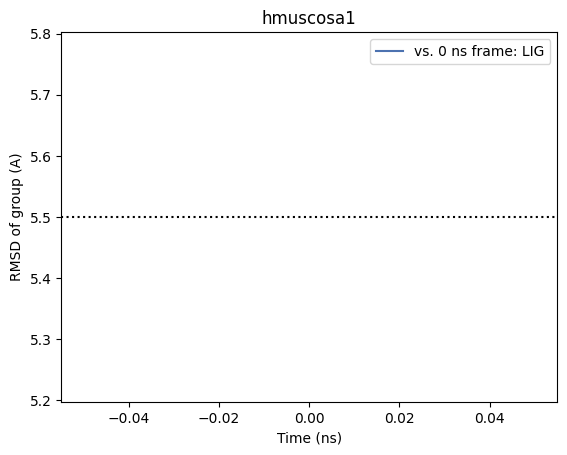

In [34]:
#@markdown **Plot computed RMSD data.** Tabular output from an RMSD analysis (above) may be visualised as a plot.
#@markdown
#@markdown Multiple RMSD groups and/or frames of reference may be specified as a comma separated list, in which case multiple plots will be made on the same axes.
rmsd_groups = "LIG" #@param {type: "string"}
reference_ps = "0, 0-1000" #@param {type: "string"}
#@markdown Optionally, plot a threshold line (on the $y$-axis) at a particular RMSD value. (0 to disable.)
threshold_A = 5.5 #@param {type: "number"}
#@markdown Optionally, cut off the plot at a particular maximum time. (0 to disable.)
max_t_ns = 0 #@param {type: "number"}
# defaults:    "LIG"    "0, 0-1000"    5.5    0
# ""
#@markdown <font size=5> </font>
#@markdown <small>*Input:* `dat.{output_prefix}_rmsd_{rmsd_group}_{reference_ps}.csv` \\
#@markdown *Output:* `dat.{output_prefix}_rmsd_{rmsd_groups}_{ranges_ps}.png`</small>

rmsd_groups = rmsd_groups.replace(" ", "").split(",")
ranges_ps = reference_ps.replace(" ", "").split(",")


#
# Get the data from the various RMSD files
#

import pandas as pd

t_ = "Time_(ns)"
y_ = "RMSD_(A)"

groups, ranges, labels, tables = list(), list(), list(), list()
for g in rmsd_groups:
  for r in ranges_ps:
    try:
      df = pd.read_csv(f"dat.{output_prefix}_rmsd_{g}_{r}.csv")
    except:
      continue

    groups.append(g)
    ranges.append(r)
    if "-" in r:
      start = float(r.split("-")[0]) / 1000.
      labels.append(f"vs. {r} ns centroid: {g}")
    else:
      start = float(r) / 1000.
      labels.append(f"vs. {r} ns frame: {g}")

    # Apply $t$ range
    df = df[(df[t_] >= start)]
    if max_t_ns > 0.:
      df = df[(df[t_] <= max_t_ns)]
    tables.append(df)


#
# Plot
#

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoLocator

def moving_average(df):
  return df.rolling(21, center=True).mean()

plt.figure()

with sns.color_palette("deep", n_colors=len(tables)):
  for l, df in zip(labels, tables):
    plt.plot(df[t_], df[y_], alpha=0.1)

  for l, df in zip(labels, tables):  # loop again to use same colours
    smooth = moving_average(df)
    plt.plot(smooth[t_], smooth[y_], label=l)

  plt.legend()

  if threshold_A != 0.:
    plt.axhline(y=threshold_A, color="black", linestyle=":")

# Title and axis labels
plt.title(os.path.basename(project_folder).replace("_", " ").replace("vs ", "vs. "))
plt.xlabel("Time (ns)")
plt.ylabel(f"RMSD of group (A)")

# Set x-axis ticks
ticker = AutoLocator()
ticker.set_params(steps=[1, 2, 3, 5, 10] if round(df[t_].values[-1]) % 3 == 0 else [1, 2, 5, 10], min_n_ticks=6)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker)

# Set y-axis limit
if any(max(df[y_]) > 16. for df in tables):
  ax.set_ylim([0, 16.])


#
# Output
#

groups_name = "_".join(rmsd_groups)
ranges_name = "_".join(ranges_ps)
name = f"{output_prefix}_rmsd_{groups_name}_{ranges_name}"
plt.gcf().savefig(f"dat.{name}.png")
plt.show()

print("***")
print(f"Made:  dat.{name}.pdf")
print("***")

  \

In [30]:
%%bash -s "$output_prefix"
exec 3>&1
if $VERBOSE; then
  exec 2>&1  # fix stderr and stdout appearing out of order
else
  exec >/dev/null 2>/dev/null  # silence
fi
output_prefix="$1"

#@markdown **Compute atom pair distance over time data** for the trajectory.

#@markdown The atom numbers (IDs) of the atoms to measure the distance between. These are found in e.g. the `conf.gro` file for the system.
pair_label="A-B" #@param {type: "string"}
atom_a=1234 #@param {type: "integer"}
atom_b=5678 #@param {type: "integer"}

#@markdown (Please note that GROMACS and VMD use atom numbers which are different by $1$. If you use the VMD picker tool to inspect an atom and it says its number is $1000$, please type $1001$ above.)
#@markdown
#@markdown <font size=5> </font>
#@markdown <small>*Output:* `dat.{output_prefix}_distance_{pair_label}_0.csv`</small>

source "/home/aistudio/gromacs/bin/GMXRC.bash"

cat > "dist.ndx" <<EOS
[ Distance ]
${atom_a} ${atom_b}
EOS

gmx distance -s "${output_prefix}.tpr" -f "${output_prefix}_reference.xtc" -n "dist.ndx" -oall "dist.xvg" <<< "Distance"

name="${output_prefix}_distance_${pair_label}_0"
{
  echo "Time_(ns),RMSD_(A)"
  sed '/^[@#]/d' "dist.xvg" | awk '{ print $1/1000","$2*10 }'
} > "dat.${name}.csv"

for i in $(seq 5); do echo ""; done
{
  echo "***"
  echo "Information: compared these atoms:"
  awk "NR == ${atom_a} + 2" "conf.gro"
  awk "NR == ${atom_b} + 2" "conf.gro"
  echo "Made:  dat.${name}.csv"
  echo "***"
} >&3

***
Information: compared these atoms:
   29DPPC   O22 1234   2.916   3.825   5.140  0.7562  0.2139 -0.1075
   63DPPC   H6S 5678   0.930   3.150   5.066  0.7186 -0.6163 -0.7106
Made:  dat.sim_distance_A-B_0.csv
***


  \

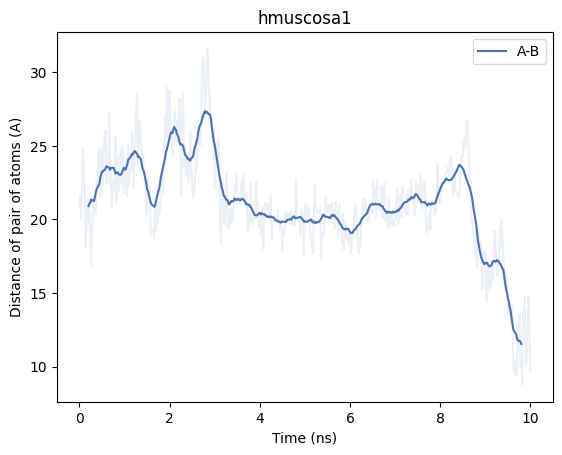

***
Made:  dat.sim_distance_A-B_0.pdf
***


In [33]:
#@markdown **Plot computed atom pair data.** Tabular output from an atom pair distance analysis (above) may be visualised as a plot.
#@markdown
#@markdown Multiple atom pair labels may be specified as a comma separated list, in which case multiple plots will be made on the same axes.
pair_labels = "A-B" #@param {type: "string"}
#@markdown Optionally, plot a threshold line (on the $y$-axis) at a particular distance value. (0 to disable.)
threshold_A = 0. #@param {type: "number"}
#@markdown Optionally, cut off the plot at a particular maximum time. (0 to disable.)
max_t_ns = 0 #@param {type: "number"}
# defaults:    "A-B"    0.    0
# ""
#@markdown <font size=5> </font>
#@markdown <small>*Input:* `dat.{output_prefix}_distance_{pair_labels}_0.csv` \\
#@markdown *Output:* `dat.{output_prefix}_rmsd_{pair_labels}_0.png`</small>

pair_labels = pair_labels.replace(" ", "").split(",")


#
# Get the data from the various distance files
#

import pandas as pd

t_ = "Time_(ns)"
y_ = "RMSD_(A)"

labels, tables = list(), list()
for p in pair_labels:
  try:
    df = pd.read_csv(f"dat.{output_prefix}_distance_{p}_0.csv")
  except:
    continue

  labels.append(p)

  # Apply $t$ range
  if max_t_ns > 0.:
    df = df[(df[t_] <= max_t_ns)]
  tables.append(df)


#
# Plot
#

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoLocator

def moving_average(df):
  return df.rolling(21, center=True).mean()

plt.figure()

with sns.color_palette("deep", n_colors=len(tables)):
  for l, df in zip(labels, tables):
    plt.plot(df[t_], df[y_], alpha=0.1)

  for l, df in zip(labels, tables):
    smooth = moving_average(df)
    plt.plot(smooth[t_], smooth[y_], label=l)

  plt.legend()

  if threshold_A != 0.:
    plt.axhline(y=threshold_A, color="black", linestyle=":")

# Title and axis labels
plt.title(os.path.basename(project_folder).replace("_", " ").replace("vs ", "vs. "))
plt.xlabel("Time (ns)")
plt.ylabel(f"Distance of pair of atoms (A)")

# Set x-axis ticks
ticker = AutoLocator()
ticker.set_params(steps=[1, 2, 3, 5, 10] if round(df[t_].values[-1]) % 3 == 0 else [1, 2, 5, 10], min_n_ticks=6)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker)


#
# Output
#

pairs_name = "_".join(pair_labels)
name = f"{output_prefix}_distance_{pairs_name}_0"
plt.gcf().savefig(f"dat.{name}.png")
plt.show()

print("***")
print(f"Made:  dat.{name}.pdf")
print("***")

  \

In [35]:
%%bash -s "$output_prefix"
output_prefix="$1"
exec 3>&1
if $VERBOSE; then
  exec 2>&1  # fix stderr and stdout appearing out of order
else
  exec >/dev/null 2>/dev/null  # silence
fi
set +H  # turn off history expansion so phrases that look like "!..." don't break

#@markdown **Compute an energy analysis** for a **protein-ligand complex**, by rewatching an existing simulation. The calculated energies are the averages for the specified time range.
#@markdown
#@markdown (This may take a minute.)
energy_group="LIG" #@param {type: "string"}
start_ps=0 #@param {type: "integer"}
end_ps=1000 #@param {type: "integer"}

source "/home/aistudio/gromacs/bin/GMXRC.bash"


#
# Energy monitoring rerun of simulation with protein
#

if ! fgrep -q "Surround" "index.ndx"; then
  group_id=$(fgrep '[' "index.ndx" | wc -l)
  { echo "! \"${energy_group}\""; echo "name ${group_id} Surround"; echo "q"; } | gmx make_ndx -f "conf.gro" -n "index.ndx" -o "index.ndx"
fi

( cat "grompp.mdp"; echo "energygrps = Surround ${energy_group}" ) > "lie_protein.mdp"
[[ ! -s "restraint.gro" ]] && cp "conf.gro" "restraint.gro"
gmx grompp -f "lie_protein.mdp" -o "lie_protein.tpr" -c "conf.gro" -p "topol.top" -r "restraint.gro" -n "index.ndx" -maxwarn 999

# Use .trr or .xtc for the rerun?
trr_frames="$(gmx check -f "${output_prefix}.trr" 2>&1 | awk '$1 ~ /^Coords/ { print $2 }')"
xtc_frames="$(gmx check -f "${output_prefix}.xtc" 2>&1 | awk '$1 ~ /^Coords/ { print $2 }')"
(( ${trr_frames:- 0} >= ${xtc_frames:- 0} )) && rerun="${output_prefix}.trr" || rerun="${output_prefix}.xtc"

gmx trjconv -s "${output_prefix}.tpr" -f "${rerun}" -e $end_ps -o "rerun.trr" <<< "0"

gmx mdrun -deffnm "lie_protein" -rerun "rerun.trr"


#
# Output the energy
#

read -r protein_qq protein_lj < <({
  echo "Coul-SR:Surround-${energy_group}";
  echo "LJ-SR:Surround-${energy_group}";
  echo;
} | gmx energy -f "lie_protein.edr" -b $start_ps -e $end_ps 2>/dev/null | tail -n2 | awk '{ print $2 }' | tr "\n" " ")

protein_total="$(perl -le "print(${protein_qq} + ${protein_lj})")"

for i in $(seq 5); do echo ""; done
{
  echo "***"
  echo "Total interaction energy (ligand with protein):  ${protein_total}"
  echo "Electrostatics term:  ${protein_qq}"
  echo "Van der Waals term:  ${protein_lj}"
  echo "***"
} >&3

***
Total interaction energy (ligand with protein):  
Electrostatics term:  
Van der Waals term:  
***


  \

In [36]:
%%bash -s "$output_prefix"
output_prefix="$1"
exec 3>&1
if $VERBOSE; then
  exec 2>&1  # fix stderr and stdout appearing out of order
else
  exec >/dev/null 2>/dev/null  # silence
fi
set +H  # turn off history expansion so phrases that look like "!..." don't break

#@markdown **Compute an energy analysis** for the **ligand in only solvent**, by computing a new simulation in a box of water.
#@markdown
#@markdown (This may take ten minutes.)
energy_group="LIG" #@param {type: "string"}

source "/home/aistudio/gromacs/bin/GMXRC.bash"


#
# Simulate ligand in solvent
#

gmx trjconv -s "${output_prefix}.tpr" -f "rerun.trr" -n "index.ndx" -dump 1000 -o "ligand.gro" <<< "${energy_group}"

gmx editconf -f "ligand.gro" -o "out.gro" -c -d 1.0 -bt "dodecahedron"
mv "out.gro" "ligand.gro"

sed -E '/\[\s*molecules\s*\]/q' "topol.top" > "ligand.top"
echo "${energy_group} 1" >> "ligand.top"

# Put the full CHARMM36 forcefield first, deleting other forcefield.itps, to ensure TIP3 and ions are included
# (This makes the assumption that the input system uses CHARMM36)
awk '! x && $0 ~ /^#include/ { x=1; print "#include \"'"${START}"'/charmm36.ff/forcefield.itp\"" }; $0 !~ /forcefield.itp/ { print }' "ligand.top" > "ligand.top.tmp"
mv "ligand.top.tmp" "ligand.top"

# Solvate with TIP3
sed 's/SOL /TIP3/g' "/usr/local/gromacs/share/gromacs/top/spc216.gro" > "TIP3.gro"
gmx solvate -cp "ligand.gro" -cs "TIP3.gro" -o "out.gro" -p "ligand.top"
mv "out.gro" "ligand.gro"


#
# Minimisation
#

cat > "ligand_min.mdp" <<EOS
; See GROMACS_for_CHARMM-GUI.ipynb

integrator            =  steep
emtol                 =  1000.0
nsteps                =  5000

cutoff-scheme         =  Verlet
nstlist               =  10
coulombtype           =  PME
rcoulomb              =  1.2
vdwtype               =  Cut-off
vdw-modifier          =  Force-switch
rvdw-switch           =  1.0
rvdw                  =  1.2

constraints           =  h-bonds
constraint-algorithm  =  LINCS
EOS

gmx grompp -f "ligand_min.mdp" -o "ligand_min.tpr" -c "ligand.gro" -p "ligand.top" -maxwarn 999

gmx genion -s "ligand_min.tpr" -o "out.gro" -p "ligand.top" -pname "POT" -nname "CLA" -neutral <<< "TIP3"
mv "out.gro" "ligand.gro"

gmx grompp -f "ligand_min.mdp" -o "ligand.tpr" -c "ligand.gro" -p "ligand.top" -maxwarn 999

gmx mdrun -v -stepout 1000 -deffnm "ligand_min"
ret=$?; if (( $ret != 0 )); then exit $ret; fi


#
# Equilibration
#

cat > "ligand_eq.mdp" <<EOS
; See GROMACS_for_CHARMM-GUI.ipynb

integrator  =  md
dt          =  0.001     ; 1 fs
nsteps      =  100000    ; 100 ps simulation time
comm-mode   =  Linear

cutoff-scheme  =  Verlet
nstlist        =  20
coulombtype    =  PME
rcoulomb       =  1.2
vdwtype        =  Cut-off
vdw-modifier   =  Force-switch
rvdw-switch    =  1.0
rvdw           =  1.2

tcoupl   = Berendsen
tc-grps  = System
tau-t    = 1.0
ref-t    = 303.15

pcoupl            = Berendsen
pcoupltype        = isotropic
tau-p             = 5.0
compressibility   = 4.5e-5
ref-p             = 1.0
refcoord-scaling  = com

constraints           =  h-bonds
constraint-algorithm  =  LINCS
continuation          =  yes
EOS

gmx grompp -f "ligand_eq.mdp" -o "ligand_eq.tpr" -c "ligand_min.gro" -p "ligand.top" -maxwarn 999

gmx mdrun -v -stepout 1000 -deffnm "ligand_eq"
ret=$?; if (( $ret != 0 )); then exit $ret; fi


#
# Production
#

cat > "ligand_prod.mdp" <<EOS
; See GROMACS_for_CHARMM-GUI.ipynb

integrator  =  md
dt          =  0.002     ; 2 fs
nsteps      =  50000     ; 100 ps simulation time
comm-mode   =  Linear

nstxout  =  5000    ; 10 frames total
nstvout  =  5000

cutoff-scheme  =  Verlet
nstlist        =  20
coulombtype    =  PME
rcoulomb       =  1.2
vdwtype        =  Cut-off
vdw-modifier   =  Force-switch
rvdw-switch    =  1.0
rvdw           =  1.2

tcoupl   =  V-Rescale
tc-grps  =  System
tau-t    =  1.0
ref-t    =  303.15

pcoupl           =  Parrinello-Rahman
pcoupltype       =  isotropic
tau-p            =  5.0
compressibility  =  4.5e-5
ref-p            =  1.0

constraints           =  h-bonds
constraint-algorithm  =  LINCS
continuation          =  yes
EOS

gmx grompp -f "ligand_prod.mdp" -o "ligand_prod.tpr" -c "ligand_eq.gro" -p "ligand.top" -maxwarn 999

gmx mdrun -v -stepout 1000 -deffnm "ligand_prod"
ret=$?; if (( $ret != 0 )); then exit $ret; fi


#
# Energy monitoring rerun of simulation with ligand
#

echo "q" | gmx make_ndx -f "ligand_min.gro" -o "ligand.ndx"
group_id=$(fgrep '[' "ligand.ndx" | wc -l)
{ echo "! \"${energy_group}\""; echo "name ${group_id} Surround"; echo "q"; } | gmx make_ndx -f "ligand_min.gro" -n "ligand.ndx" -o "ligand.ndx"

( cat "ligand_prod.mdp"; echo "energygrps = ${energy_group} Surround" ) > "lie_ligand.mdp"
gmx grompp -f "lie_ligand.mdp" -o "lie_ligand.tpr" -c "ligand_min.gro" -p "ligand.top" -n "ligand.ndx" -maxwarn 999

gmx mdrun -deffnm "lie_ligand" -rerun "ligand_prod.trr"


#
# Output the energy
#

read -r ligand_qq ligand_lj < <({
  echo "Coul-SR:${energy_group}-Surround";
  echo "LJ-SR:${energy_group}-Surround";
  echo;
} | gmx energy -f "lie_ligand.edr" 2>/dev/null | tail -n2 | awk '{ print $2 }' | tr "\n" " ")

ligand_total="$(perl -le "print(${ligand_qq} + ${ligand_lj})")"

for i in $(seq 5); do echo ""; done
{
  echo "***"
  echo "Total interaction energy (ligand with solvent):  ${ligand_total}"
  echo "Electrostatics term:  ${ligand_qq}"
  echo "Van der Waals term:  ${ligand_lj}"
  echo "***"
} >&3

CalledProcessError: Command 'b'output_prefix="$1"\nexec 3>&1\nif $VERBOSE; then\n  exec 2>&1  # fix stderr and stdout appearing out of order\nelse\n  exec >/dev/null 2>/dev/null  # silence\nfi\nset +H  # turn off history expansion so phrases that look like "!..." don\'t break\n\n#@markdown **Compute an energy analysis** for the **ligand in only solvent**, by computing a new simulation in a box of water.\n#@markdown\n#@markdown (This may take ten minutes.)\nenergy_group="LIG" #@param {type: "string"}\n\nsource "/home/aistudio/gromacs/bin/GMXRC.bash"\n\n\n#\n# Simulate ligand in solvent\n#\n\ngmx trjconv -s "${output_prefix}.tpr" -f "rerun.trr" -n "index.ndx" -dump 1000 -o "ligand.gro" <<< "${energy_group}"\n\ngmx editconf -f "ligand.gro" -o "out.gro" -c -d 1.0 -bt "dodecahedron"\nmv "out.gro" "ligand.gro"\n\nsed -E \'/\\[\\s*molecules\\s*\\]/q\' "topol.top" > "ligand.top"\necho "${energy_group} 1" >> "ligand.top"\n\n# Put the full CHARMM36 forcefield first, deleting other forcefield.itps, to ensure TIP3 and ions are included\n# (This makes the assumption that the input system uses CHARMM36)\nawk \'! x && $0 ~ /^#include/ { x=1; print "#include \\"\'"${START}"\'/charmm36.ff/forcefield.itp\\"" }; $0 !~ /forcefield.itp/ { print }\' "ligand.top" > "ligand.top.tmp"\nmv "ligand.top.tmp" "ligand.top"\n\n# Solvate with TIP3\nsed \'s/SOL /TIP3/g\' "/usr/local/gromacs/share/gromacs/top/spc216.gro" > "TIP3.gro"\ngmx solvate -cp "ligand.gro" -cs "TIP3.gro" -o "out.gro" -p "ligand.top"\nmv "out.gro" "ligand.gro"\n\n\n#\n# Minimisation\n#\n\ncat > "ligand_min.mdp" <<EOS\n; See GROMACS_for_CHARMM-GUI.ipynb\n\nintegrator            =  steep\nemtol                 =  1000.0\nnsteps                =  5000\n\ncutoff-scheme         =  Verlet\nnstlist               =  10\ncoulombtype           =  PME\nrcoulomb              =  1.2\nvdwtype               =  Cut-off\nvdw-modifier          =  Force-switch\nrvdw-switch           =  1.0\nrvdw                  =  1.2\n\nconstraints           =  h-bonds\nconstraint-algorithm  =  LINCS\nEOS\n\ngmx grompp -f "ligand_min.mdp" -o "ligand_min.tpr" -c "ligand.gro" -p "ligand.top" -maxwarn 999\n\ngmx genion -s "ligand_min.tpr" -o "out.gro" -p "ligand.top" -pname "POT" -nname "CLA" -neutral <<< "TIP3"\nmv "out.gro" "ligand.gro"\n\ngmx grompp -f "ligand_min.mdp" -o "ligand.tpr" -c "ligand.gro" -p "ligand.top" -maxwarn 999\n\ngmx mdrun -v -stepout 1000 -deffnm "ligand_min"\nret=$?; if (( $ret != 0 )); then exit $ret; fi\n\n\n#\n# Equilibration\n#\n\ncat > "ligand_eq.mdp" <<EOS\n; See GROMACS_for_CHARMM-GUI.ipynb\n\nintegrator  =  md\ndt          =  0.001     ; 1 fs\nnsteps      =  100000    ; 100 ps simulation time\ncomm-mode   =  Linear\n\ncutoff-scheme  =  Verlet\nnstlist        =  20\ncoulombtype    =  PME\nrcoulomb       =  1.2\nvdwtype        =  Cut-off\nvdw-modifier   =  Force-switch\nrvdw-switch    =  1.0\nrvdw           =  1.2\n\ntcoupl   = Berendsen\ntc-grps  = System\ntau-t    = 1.0\nref-t    = 303.15\n\npcoupl            = Berendsen\npcoupltype        = isotropic\ntau-p             = 5.0\ncompressibility   = 4.5e-5\nref-p             = 1.0\nrefcoord-scaling  = com\n\nconstraints           =  h-bonds\nconstraint-algorithm  =  LINCS\ncontinuation          =  yes\nEOS\n\ngmx grompp -f "ligand_eq.mdp" -o "ligand_eq.tpr" -c "ligand_min.gro" -p "ligand.top" -maxwarn 999\n\ngmx mdrun -v -stepout 1000 -deffnm "ligand_eq"\nret=$?; if (( $ret != 0 )); then exit $ret; fi\n\n\n#\n# Production\n#\n\ncat > "ligand_prod.mdp" <<EOS\n; See GROMACS_for_CHARMM-GUI.ipynb\n\nintegrator  =  md\ndt          =  0.002     ; 2 fs\nnsteps      =  50000     ; 100 ps simulation time\ncomm-mode   =  Linear\n\nnstxout  =  5000    ; 10 frames total\nnstvout  =  5000\n\ncutoff-scheme  =  Verlet\nnstlist        =  20\ncoulombtype    =  PME\nrcoulomb       =  1.2\nvdwtype        =  Cut-off\nvdw-modifier   =  Force-switch\nrvdw-switch    =  1.0\nrvdw           =  1.2\n\ntcoupl   =  V-Rescale\ntc-grps  =  System\ntau-t    =  1.0\nref-t    =  303.15\n\npcoupl           =  Parrinello-Rahman\npcoupltype       =  isotropic\ntau-p            =  5.0\ncompressibility  =  4.5e-5\nref-p            =  1.0\n\nconstraints           =  h-bonds\nconstraint-algorithm  =  LINCS\ncontinuation          =  yes\nEOS\n\ngmx grompp -f "ligand_prod.mdp" -o "ligand_prod.tpr" -c "ligand_eq.gro" -p "ligand.top" -maxwarn 999\n\ngmx mdrun -v -stepout 1000 -deffnm "ligand_prod"\nret=$?; if (( $ret != 0 )); then exit $ret; fi\n\n\n#\n# Energy monitoring rerun of simulation with ligand\n#\n\necho "q" | gmx make_ndx -f "ligand_min.gro" -o "ligand.ndx"\ngroup_id=$(fgrep \'[\' "ligand.ndx" | wc -l)\n{ echo "! \\"${energy_group}\\""; echo "name ${group_id} Surround"; echo "q"; } | gmx make_ndx -f "ligand_min.gro" -n "ligand.ndx" -o "ligand.ndx"\n\n( cat "ligand_prod.mdp"; echo "energygrps = ${energy_group} Surround" ) > "lie_ligand.mdp"\ngmx grompp -f "lie_ligand.mdp" -o "lie_ligand.tpr" -c "ligand_min.gro" -p "ligand.top" -n "ligand.ndx" -maxwarn 999\n\ngmx mdrun -deffnm "lie_ligand" -rerun "ligand_prod.trr"\n\n\n#\n# Output the energy\n#\n\nread -r ligand_qq ligand_lj < <({\n  echo "Coul-SR:${energy_group}-Surround";\n  echo "LJ-SR:${energy_group}-Surround";\n  echo;\n} | gmx energy -f "lie_ligand.edr" 2>/dev/null | tail -n2 | awk \'{ print $2 }\' | tr "\\n" " ")\n\nligand_total="$(perl -le "print(${ligand_qq} + ${ligand_lj})")"\n\nfor i in $(seq 5); do echo ""; done\n{\n  echo "***"\n  echo "Total interaction energy (ligand with solvent):  ${ligand_total}"\n  echo "Electrostatics term:  ${ligand_qq}"\n  echo "Van der Waals term:  ${ligand_lj}"\n  echo "***"\n} >&3\n'' returned non-zero exit status 1.